Цель работы:
- получить навыки реализации нейронных сетей для решения
задачи много классовой классификации объектов на изображениях. В качестве
объектов на изображениях будут использоваться несколько видов листьев,
подверженных различным заболеваниям

# Загрузка данных

In [ ]:
INPUT_SHAPE = (224, 224, 3) # as in ResNet
INPUT_SHAPE[:2]

(224, 224)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
from tqdm import tqdm
import numpy as np
from PIL import Image


CLASS_MAPPING = {
    'potato_sick_late': 0,
    'potato_sick_early': 1,
    'potato_healthy': 2
}

def download_data(path_dataset, resize_len=INPUT_SHAPE[:2]):
    '''resize_len=224 as in AlexNet'''
    dataset = []
    datalabel = []

    for path_dir in sorted(os.listdir(path=path_dataset)):
        path = path_dataset + path_dir + '/'

        for filename in tqdm(sorted(os.listdir(path=path)), desc=path_dir):
            img = Image.open(path + filename).resize(resize_len)
            img = np.array(img)[:, :, :3] # RGBA (PNG) -> RGB

            label = CLASS_MAPPING[path_dir.lower()]

            dataset.append(img.astype(np.uint8))
            datalabel.append(label)

    return np.array(dataset), np.array(datalabel)

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, data, y):
        self.data=data
        self.y = y
        self.transform = transforms.Compose(
            [transforms.ToTensor()] # (H, W, C) - > (C, H, W)
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        img = self.transform(img)

        target = self.y[idx]
        return img, torch.tensor(target).long()

In [ ]:
main_dir = r"/content/drive/MyDrive/Colab Notebooks/materials/Plants/"

print('TRAIN:')
train_dataset, y_train = download_data(main_dir + r"Train/")
train_dataset = CustomDataset(train_dataset, y_train)

print('\nTEST:')
test_dataset, y_test = download_data(main_dir + r"Test/")
test_dataset = CustomDataset(test_dataset, y_test)

TRAIN:


Potato_sick_late: 100%|██████████| 700/700 [00:19<00:00, 36.61it/s] 



TEST:


Potato_sick_late: 100%|██████████| 300/300 [00:08<00:00, 35.79it/s] 


In [ ]:
import matplotlib.pyplot as plt

def img_print(ds, inc=0):
    plt.figure(figsize=(14, 14))
    for i in range(8):
        # Creates 1 row, 8 columns, i+1 positions 1-8 (left to right)
        plt.subplot(1, 8, i+1)
        # Removes x/y axis ticks for clean image display
        plt.xticks([])
        plt.yticks([])

        img = ds[i+inc][0]               # Gets image tensor [C, H, W] (normalized 0-1)
        img = img*255                           # Denormalize → pixel values 0-255
        img = img.transpose(2,0).int().numpy()  # [C,H,W] → [H,W,C]

        plt.imshow(img, cmap=plt.cm.binary)
        plt.text(10, 12, 'healthy', color='white', backgroundcolor='black', fontsize=10)

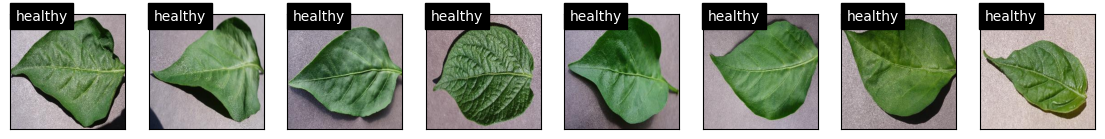

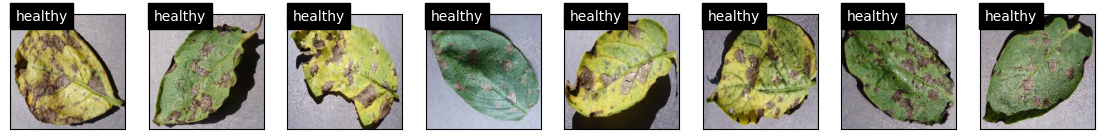

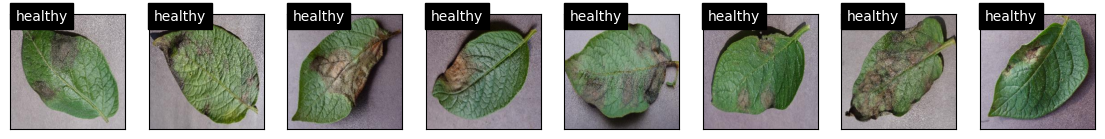

In [ ]:
img_print(train_dataset)
img_print(train_dataset, inc=900)
img_print(train_dataset, inc=1600)

# Реализация топологии нейронной сети

| | |
| --------------- | --------------- |
| ![image-2.png](attachment:image-2.png) | ![image.png](attachment:image.png) |

| Layer                | Type                                        | Params                                     | Output Shape |
| -------------------- | ------------------------------------------- | ------------------------------------------ | ------------ |
| Input                | -                                           | -                                          | 3×224×224    |
| Conv1                | 7×7×64, stride=2, pad=3                     | 64×7×7×3=9408                              | 64×112×112   |
| BN1 + ReLU           | BatchNorm                                   | -                                          | 64×112×112   |
| MaxPool              | 3×3, stride=2, pad=1                        | -                                          | 64×56×56     |
| Layer1 (2× ResBlock) |                                             |                                            |              |
| ResBlock1            | 3×3×64→64 + 3×3×64 (stride=1)               | 64×3×3×64×2=36864                          | 64×56×56     |
| ResBlock2            | 3×3×64→64 + 3×3×64                          | 64×3×3×64×2=36864                          | 64×56×56     |
| Layer2 (2× ResBlock) |                                             |                                            |              |
| ResBlock1            | 3×3×64→128 + 3×3×128 (stride=2) + 1×1 proj  | 128×3×3×64+128×3×3×128+128×1×1×64=221184   | 128×28×28    |
| ResBlock2            | 3×3×128→128 + 3×3×128                       | 128×3×3×128×2=73728                        | 128×28×28    |
| Layer3 (2× ResBlock) |                                             |                                            |              |
| ResBlock1            | 3×3×128→256 + 3×3×256 (stride=2) + 1×1 proj | 256×3×3×128+256×3×3×256+256×1×1×128=884736 | 256×14×14    |
| ResBlock2            | 3×3×256→256 + 3×3×256                       | 256×3×3×256×2=589824                       | 256×14×14    |
| AdaptiveAvgPool      | GlobalAvgPool                               | -                                          | 256×1×1      |
| Flatten              | -                                           | -                                          | 256          |
| FC                   | Linear(256→3)                               | 256×3=768                                  | 3            |

In [ ]:
import torch.nn as nn

# Add inplace=True to the ReLU - standard ResNet practice,
# saves ~1/3 memory with no gradient issues.

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, is_downsample=False):
        super(ResidualBlock, self).__init__()
        self.is_downsample = is_downsample

        self.relu = nn.ReLU(inplace=True)

        self.full = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False
            ),
            nn.BatchNorm2d(num_features=out_channels),
            self.relu,

            nn.Conv2d(
                in_channels=out_channels, out_channels=out_channels,
                kernel_size=3, stride=1, padding=1, bias=False
            ),
            nn.BatchNorm2d(num_features=out_channels)
        )

        self.downsample = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=1, stride=stride, bias=False
            ),
            nn.BatchNorm2d(num_features=out_channels)
        )

    def forward(self, x):
        out = self.full(x)

        if self.is_downsample:
            identity = self.downsample(x)
            out += identity

        out = self.relu(out)
        return out


class CustomResNet(nn.Module):
    def __init__(self, num_classes=3, in_channels=64):
        super(CustomResNet, self).__init__()

        # First ResNet layer
        self.layer0 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=in_channels,
                kernel_size=7, stride=2, padding=3, bias=False
            ),
            nn.BatchNorm2d(num_features=in_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Residual blocks: 2*2*2=6 blocks - ResNet-6
        self.layer1 = self._make_residual_layer(in_channels, in_channels, 2)    # 2*64 blocks
        self.layer2 = self._make_residual_layer(in_channels, 128, 2, stride=2)  # 64->128*2 blocks
        self.layer3 = self._make_residual_layer(128, 256, 2, stride=2)          # 128->256*2 blocks

        # Converts feature map to vector batch_size*(256, 1, 1)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        # Finall classification layer
        self.fc = nn.Linear(256, num_classes)

    def _make_residual_layer(self, in_channel, out_channels, num_blocks, stride=1):
        is_downsample = False

        if stride != 1 or in_channel != out_channels:
            is_downsample = True

        layers = []
        layers.append(
            ResidualBlock(
                in_channels=in_channel, out_channels=out_channels,
                stride=stride, is_downsample=is_downsample
            )
        )

        for _ in range(1, num_blocks):
            layers.append(
                ResidualBlock(in_channels=out_channels, out_channels=out_channels)
            )

        return nn.Sequential(*layers)


    def forward(self, x):
        out = self.layer0(x)            # [B, 64, H/4, W/4]

        out = self.layer1(out)          # 64 -> 64
        out = self.layer2(out)          # 64 -> 128
        out = self.layer3(out)          # 128 -> 256

        out = self.avgpool(out)         # [B, 256, 1, 1]
        out = torch.flatten(out, 1)     # [B, 256]
        out = self.fc(out)
        out = torch.softmax(out, dim=1) # [B, num_classes]

        return out


In [ ]:
# Model example
import torch

model = CustomResNet()
x = torch.randn(32, 3, 224, 224)  # Batch of 32 images
output = model(x)
print(output.shape)
output[0]

torch.Size([32, 3])


tensor([0.2821, 0.3859, 0.3320], grad_fn=<SelectBackward0>)

# Обучение и тестирование нейронной сети


In [ ]:
BUTCH_SIZE = 32
NUM_CLASSES = 3
NUM_EPOCHS = 10
LR=0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEVICE

device(type='cuda')

In [ ]:
def train_val(train_loader, val_loader, model, criterion, optimizer):
    train_accs, val_accs, train_losses, val_losses = [], [], [], []

    for epoch in range(NUM_EPOCHS):
        # ~~~> 1. Learning epoch
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        train_loader_tqdm = tqdm(
            train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} - Training', unit='batch'
        )
        for batch_idx, (imgs, labels) in enumerate(train_loader_tqdm):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE).long()

            optimizer.zero_grad()
            outputs = model(imgs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, pred = torch.max(outputs, dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)

            # Calculate online average loss and accuracy
            current_batch = batch_idx + 1
            avg_loss = running_loss / current_batch
            avg_acc = correct / total if total > 0 else 0.0

            train_loader_tqdm.set_postfix(
                loss=f'{avg_loss:.4f}',
                acc=f'{avg_acc:.4f}',
            )

        # Avg val epoch loss
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # ~~~> 2. Validation epoch
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE).long()

                outputs = model(imgs)

                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, pred = torch.max(outputs, dim=1)
                val_correct += (pred == labels).sum().item()
                val_total += labels.size(0)

        # Avg val epoch loss
        val_loss = val_running_loss / len(val_loader)
        val_acc = val_correct / val_total

        # ~~~> 3. Save epoxh metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(
            f"Epoch [{epoch+1}/{NUM_EPOCHS}]:"
            f"\n\t- train loss: {train_loss:.4f}"
            f"\n\t- train acc: {train_acc:.4f} "
            f"\n\t- val loss: {val_loss:.4f}"
            f"\n\t- val acc: {val_acc:.4f}"
        )

    return train_losses, val_losses, train_accs, val_accs

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BUTCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BUTCH_SIZE)

In [ ]:
import torch.optim as optim

model = CustomResNet(num_classes=NUM_CLASSES).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [ ]:
train_losses, val_losses, train_accs, val_accs = train_val(
    train_loader, val_loader, model, criterion, optimizer
)

Epoch 1/10 - Training: 100%|██████████| 66/66 [00:06<00:00, 10.82batch/s, acc=0.9252, loss=0.6298]


Epoch [1/10]:
	- train loss: 0.6298
	- train acc: 0.9252 
	- val loss: 0.8244
	- val acc: 0.7222


Epoch 2/10 - Training: 100%|██████████| 66/66 [00:05<00:00, 11.28batch/s, acc=0.9286, loss=0.6257]


Epoch [2/10]:
	- train loss: 0.6257
	- train acc: 0.9286 
	- val loss: 1.1697
	- val acc: 0.3822


Epoch 3/10 - Training: 100%|██████████| 66/66 [00:06<00:00, 10.91batch/s, acc=0.9419, loss=0.6122]


Epoch [3/10]:
	- train loss: 0.6122
	- train acc: 0.9419 
	- val loss: 0.7891
	- val acc: 0.7733


Epoch 4/10 - Training: 100%|██████████| 66/66 [00:05<00:00, 11.07batch/s, acc=0.9481, loss=0.6063]


Epoch [4/10]:
	- train loss: 0.6063
	- train acc: 0.9481 
	- val loss: 0.6327
	- val acc: 0.9189


Epoch 5/10 - Training: 100%|██████████| 66/66 [00:06<00:00, 10.31batch/s, acc=0.9576, loss=0.5978]


Epoch [5/10]:
	- train loss: 0.5978
	- train acc: 0.9576 
	- val loss: 0.8131
	- val acc: 0.7367


Epoch 6/10 - Training: 100%|██████████| 66/66 [00:05<00:00, 11.05batch/s, acc=0.9576, loss=0.5920]


Epoch [6/10]:
	- train loss: 0.5920
	- train acc: 0.9576 
	- val loss: 0.6573
	- val acc: 0.8856


Epoch 7/10 - Training: 100%|██████████| 66/66 [00:06<00:00, 10.83batch/s, acc=0.9510, loss=0.5997]


Epoch [7/10]:
	- train loss: 0.5997
	- train acc: 0.9510 
	- val loss: 0.6355
	- val acc: 0.9256


Epoch 8/10 - Training: 100%|██████████| 66/66 [00:05<00:00, 11.04batch/s, acc=0.9467, loss=0.6054]


Epoch [8/10]:
	- train loss: 0.6054
	- train acc: 0.9467 
	- val loss: 0.7745
	- val acc: 0.7867


Epoch 9/10 - Training: 100%|██████████| 66/66 [00:06<00:00, 10.72batch/s, acc=0.9619, loss=0.5897]


Epoch [9/10]:
	- train loss: 0.5897
	- train acc: 0.9619 
	- val loss: 0.7267
	- val acc: 0.8267


Epoch 10/10 - Training: 100%|██████████| 66/66 [00:06<00:00, 10.85batch/s, acc=0.9629, loss=0.5890]


Epoch [10/10]:
	- train loss: 0.5890
	- train acc: 0.9629 
	- val loss: 0.5734
	- val acc: 0.9778


#  Результат работы нейронной сети

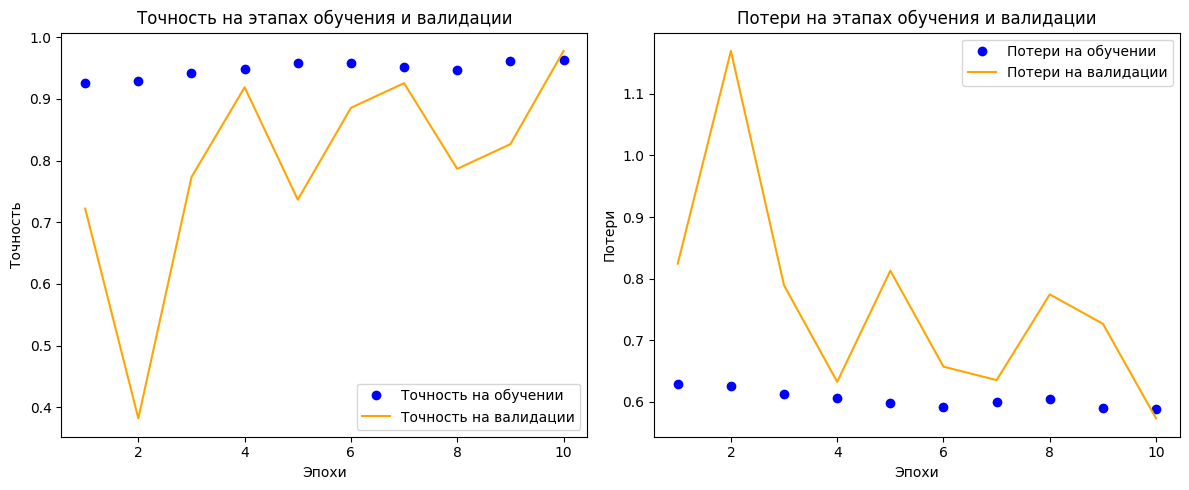

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, NUM_EPOCHS + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # One figure, two axes

# Accuracy plot
ax1.plot(epochs, train_accs, "bo", label="Точность на обучении")
ax1.plot(epochs, val_accs, color="orange", label="Точность на валидации")
ax1.set_title("Точность на этапах обучения и валидации")
ax1.set_xlabel("Эпохи")
ax1.set_ylabel("Точность")
ax1.legend()

# Loss plot
ax2.plot(epochs, train_losses, "bo", label="Потери на обучении")
ax2.plot(epochs, val_losses, color="orange", label="Потери на валидации")
ax2.set_title("Потери на этапах обучения и валидации")
ax2.set_xlabel("Эпохи")
ax2.set_ylabel("Потери")
ax2.legend()

plt.tight_layout()  # Better spacing
plt.show()


На последней эпохе удалось достигнуть сопоставимых точностей на train и val выборках:
```
	- train loss: 0.5890
	- train acc: 0.9629
	- val loss: 0.5734
	- val acc: 0.9778
```


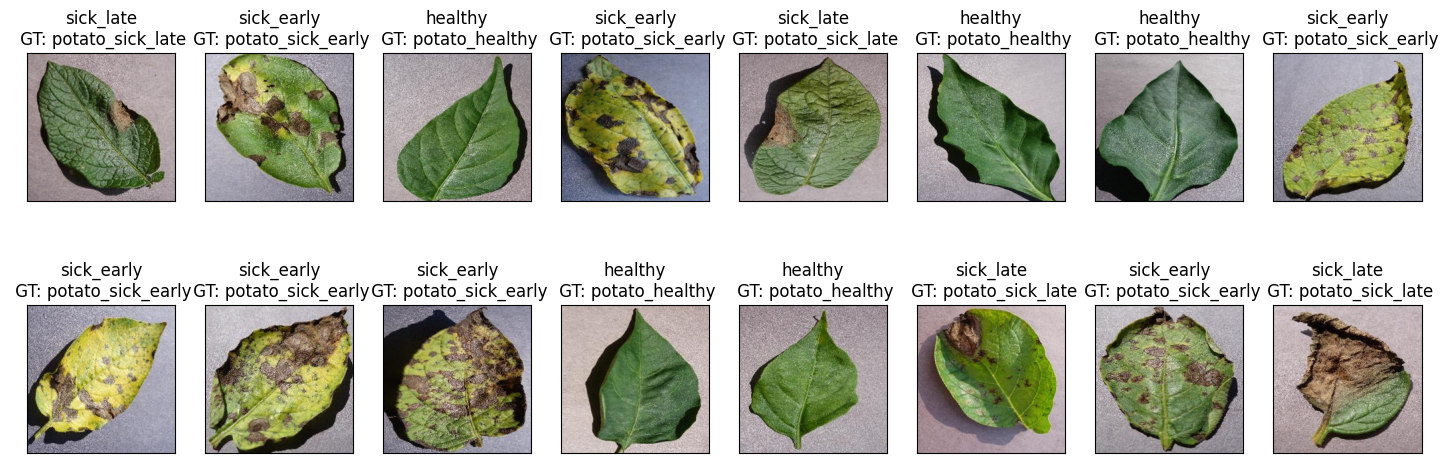

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
images, labels = next(iter(test_loader))

model.eval()
with torch.no_grad():
    outputs = model(images.to(DEVICE))
    preds = torch.argmax(outputs, dim=1).cpu().numpy()

plt.figure(figsize=(18, 6))
for i in range(16):
    plt.subplot(2, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    title = ['sick_late', 'sick_early', 'healthy'][preds[i]] + f"\n GT: {list(CLASS_MAPPING.keys())[labels[i].int().item()].replace('Potato_', '')}"
    plt.title(title)
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
plt.show()

# Доп задание #1: Использование предобученного ResNet

##  ResNet change last layer

In [ ]:
from torchvision import models

class ResNetChangeLastLayer(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNetChangeLastLayer, self).__init__()

        # Load ResNet-18
        self.fine_tuning_model = models.resnet18(pretrained=True)

        num_ftrs = self.fine_tuning_model.fc.in_features
        self.fine_tuning_model.fc = nn.Sequential(
            nn.Linear(num_ftrs, num_classes),
            # nn.Softmax(dim=1) # Commented because it already inside the loss (CrossEntropyLoss)
        )

    def forward(self, x):
        return self.fine_tuning_model(x)


In [ ]:
import torch.optim as optim

fine_tuning_model = ResNetChangeLastLayer(num_classes=NUM_CLASSES).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fine_tuning_model.parameters(), lr=LR)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_losses_ft, val_losses_ft, train_accs_ft, val_accs_ft = train_val(
    train_loader, val_loader, fine_tuning_model, criterion, optimizer
)

Epoch 1/10 - Training: 100%|██████████| 66/66 [00:07<00:00,  8.78batch/s, acc=0.9610, loss=0.1209]


Epoch [1/10]:
	- train loss: 0.1209
	- train acc: 0.9610 
	- val loss: 0.1052
	- val acc: 0.9667


Epoch 2/10 - Training: 100%|██████████| 66/66 [00:07<00:00,  8.96batch/s, acc=0.9848, loss=0.0381]


Epoch [2/10]:
	- train loss: 0.0381
	- train acc: 0.9848 
	- val loss: 0.2562
	- val acc: 0.9144


Epoch 3/10 - Training: 100%|██████████| 66/66 [00:07<00:00,  8.91batch/s, acc=0.9881, loss=0.0325]


Epoch [3/10]:
	- train loss: 0.0325
	- train acc: 0.9881 
	- val loss: 0.0495
	- val acc: 0.9833


Epoch 4/10 - Training: 100%|██████████| 66/66 [00:07<00:00,  8.87batch/s, acc=0.9848, loss=0.0395]


Epoch [4/10]:
	- train loss: 0.0395
	- train acc: 0.9848 
	- val loss: 0.3291
	- val acc: 0.9189


Epoch 5/10 - Training: 100%|██████████| 66/66 [00:07<00:00,  8.70batch/s, acc=0.9843, loss=0.0530]


Epoch [5/10]:
	- train loss: 0.0530
	- train acc: 0.9843 
	- val loss: 0.0530
	- val acc: 0.9833


Epoch 6/10 - Training: 100%|██████████| 66/66 [00:07<00:00,  8.65batch/s, acc=0.9952, loss=0.0121]


Epoch [6/10]:
	- train loss: 0.0121
	- train acc: 0.9952 
	- val loss: 0.0120
	- val acc: 0.9956


Epoch 7/10 - Training: 100%|██████████| 66/66 [00:07<00:00,  8.94batch/s, acc=0.9948, loss=0.0145]


Epoch [7/10]:
	- train loss: 0.0145
	- train acc: 0.9948 
	- val loss: 1.2537
	- val acc: 0.7189


Epoch 8/10 - Training: 100%|██████████| 66/66 [00:07<00:00,  9.12batch/s, acc=0.9952, loss=0.0145]


Epoch [8/10]:
	- train loss: 0.0145
	- train acc: 0.9952 
	- val loss: 0.0035
	- val acc: 1.0000


Epoch 9/10 - Training: 100%|██████████| 66/66 [00:07<00:00,  8.95batch/s, acc=0.9995, loss=0.0034]


Epoch [9/10]:
	- train loss: 0.0034
	- train acc: 0.9995 
	- val loss: 0.0093
	- val acc: 0.9967


Epoch 10/10 - Training: 100%|██████████| 66/66 [00:07<00:00,  8.96batch/s, acc=0.9967, loss=0.0090]


Epoch [10/10]:
	- train loss: 0.0090
	- train acc: 0.9967 
	- val loss: 0.0059
	- val acc: 0.9989


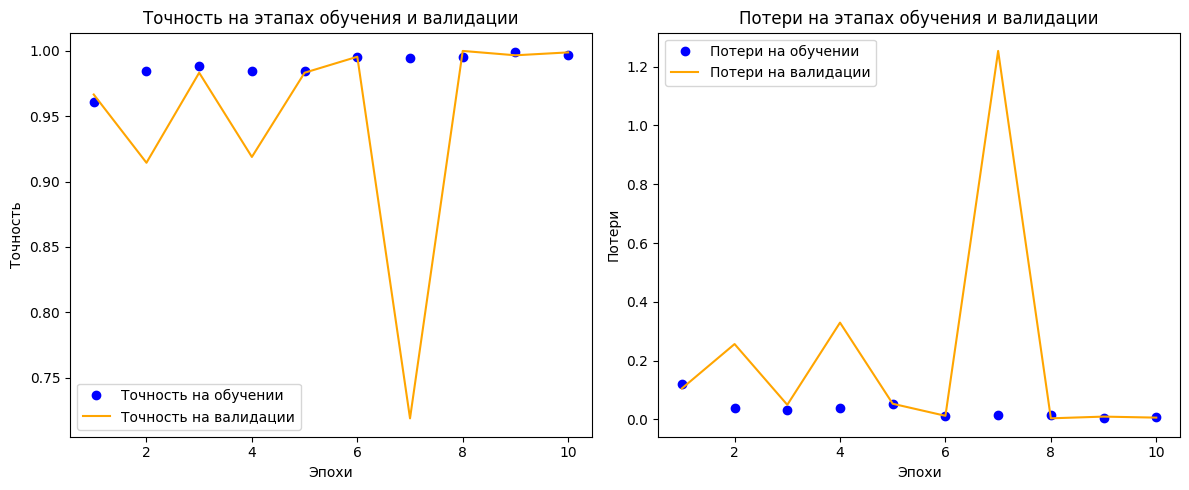

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, NUM_EPOCHS + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # One figure, two axes

# Accuracy plot
ax1.plot(epochs, train_accs_ft, "bo", label="Точность на обучении")
ax1.plot(epochs, val_accs_ft, color="orange", label="Точность на валидации")
ax1.set_title("Точность на этапах обучения и валидации")
ax1.set_xlabel("Эпохи")
ax1.set_ylabel("Точность")
ax1.legend()

# Loss plot
ax2.plot(epochs, train_losses_ft, "bo", label="Потери на обучении")
ax2.plot(epochs, val_losses_ft, color="orange", label="Потери на валидации")
ax2.set_title("Потери на этапах обучения и валидации")
ax2.set_xlabel("Эпохи")
ax2.set_ylabel("Потери")
ax2.legend()

plt.tight_layout()  # Better spacing
plt.show()


##  ResNet fine-tuning

In [ ]:
from torchvision import models

class ResNetFineTuning(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNetFineTuning, self).__init__()

        # Load ResNet-18
        self.fine_tuning_model = models.resnet18(pretrained=True)

        for param in self.fine_tuning_model.parameters():
            param.requires_grad = False

        num_ftrs = self.fine_tuning_model.fc.in_features
        self.fine_tuning_model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.fine_tuning_model(x)


In [ ]:
import torch.optim as optim

fine_tuning_model = ResNetFineTuning(num_classes=NUM_CLASSES).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fine_tuning_model.fine_tuning_model.fc.parameters(), lr=LR)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_losses_ft, val_losses_ft, train_accs_ft, val_accs_ft = train_val(
    train_loader, val_loader, fine_tuning_model, criterion, optimizer
)

Epoch 1/10 - Training: 100%|██████████| 66/66 [00:03<00:00, 19.79batch/s, acc=0.8157, loss=0.5666]


Epoch [1/10]:
	- train loss: 0.5666
	- train acc: 0.8157 
	- val loss: 0.3111
	- val acc: 0.8978


Epoch 2/10 - Training: 100%|██████████| 66/66 [00:03<00:00, 21.36batch/s, acc=0.9605, loss=0.2003]


Epoch [2/10]:
	- train loss: 0.2003
	- train acc: 0.9605 
	- val loss: 0.1704
	- val acc: 0.9700


Epoch 3/10 - Training: 100%|██████████| 66/66 [00:03<00:00, 20.77batch/s, acc=0.9681, loss=0.1425]


Epoch [3/10]:
	- train loss: 0.1425
	- train acc: 0.9681 
	- val loss: 0.1369
	- val acc: 0.9678


Epoch 4/10 - Training: 100%|██████████| 66/66 [00:03<00:00, 20.35batch/s, acc=0.9795, loss=0.1051]


Epoch [4/10]:
	- train loss: 0.1051
	- train acc: 0.9795 
	- val loss: 0.1015
	- val acc: 0.9822


Epoch 5/10 - Training: 100%|██████████| 66/66 [00:03<00:00, 21.13batch/s, acc=0.9843, loss=0.0855]


Epoch [5/10]:
	- train loss: 0.0855
	- train acc: 0.9843 
	- val loss: 0.0894
	- val acc: 0.9833


Epoch 6/10 - Training: 100%|██████████| 66/66 [00:03<00:00, 20.86batch/s, acc=0.9852, loss=0.0765]


Epoch [6/10]:
	- train loss: 0.0765
	- train acc: 0.9852 
	- val loss: 0.0860
	- val acc: 0.9767


Epoch 7/10 - Training: 100%|██████████| 66/66 [00:03<00:00, 20.27batch/s, acc=0.9810, loss=0.0808]


Epoch [7/10]:
	- train loss: 0.0808
	- train acc: 0.9810 
	- val loss: 0.0910
	- val acc: 0.9733


Epoch 8/10 - Training: 100%|██████████| 66/66 [00:03<00:00, 21.30batch/s, acc=0.9838, loss=0.0660]


Epoch [8/10]:
	- train loss: 0.0660
	- train acc: 0.9838 
	- val loss: 0.0647
	- val acc: 0.9867


Epoch 9/10 - Training: 100%|██████████| 66/66 [00:03<00:00, 18.77batch/s, acc=0.9905, loss=0.0516]


Epoch [9/10]:
	- train loss: 0.0516
	- train acc: 0.9905 
	- val loss: 0.0598
	- val acc: 0.9878


Epoch 10/10 - Training: 100%|██████████| 66/66 [00:03<00:00, 20.44batch/s, acc=0.9876, loss=0.0540]


Epoch [10/10]:
	- train loss: 0.0540
	- train acc: 0.9876 
	- val loss: 0.0577
	- val acc: 0.9856


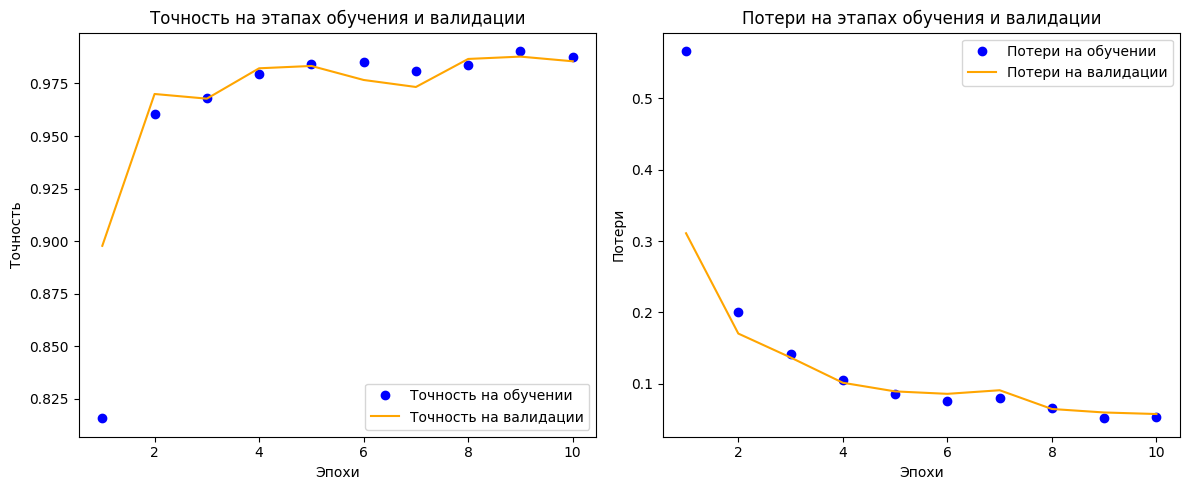

In [59]:
import matplotlib.pyplot as plt

epochs = range(1, NUM_EPOCHS + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # One figure, two axes

# Accuracy plot
ax1.plot(epochs, train_accs_ft, "bo", label="Точность на обучении")
ax1.plot(epochs, val_accs_ft, color="orange", label="Точность на валидации")
ax1.set_title("Точность на этапах обучения и валидации")
ax1.set_xlabel("Эпохи")
ax1.set_ylabel("Точность")
ax1.legend()

# Loss plot
ax2.plot(epochs, train_losses_ft, "bo", label="Потери на обучении")
ax2.plot(epochs, val_losses_ft, color="orange", label="Потери на валидации")
ax2.set_title("Потери на этапах обучения и валидации")
ax2.set_xlabel("Эпохи")
ax2.set_ylabel("Потери")
ax2.legend()

plt.tight_layout()  # Better spacing
plt.show()


# Доп задание #2: Сравнение моделей и выводы

Общие параметры для моделей:
```python
INPUT_SHAPE = (224, 224, 3)
BUTCH_SIZE = 32
NUM_CLASSES = 3
NUM_EPOCHS = 10
LR = 0.001
DEVICE = 'cuda'
```

Сводная таблица с результатами:

| | Custom model | Changed last layer model | Fine-tuning model |
| ---- | ---- | ---- | ---- |
| Final scores | - train loss: 0.5890<br>- train acc: 0.9629 <br>- val loss: 0.5734<br>- val acc: 0.9778 | - train loss: 0.0090<br>- train acc: 0.9967 <br>- val loss: 0.0059<br>- val acc: 0.9989 | - train loss: 0.0540<br>- train acc: 0.9876 <br>- val loss: 0.0577<br>- val acc: 0.9856|
| Avg batch execute time, sec | 5 | 7 | 3 |
| Graphs | 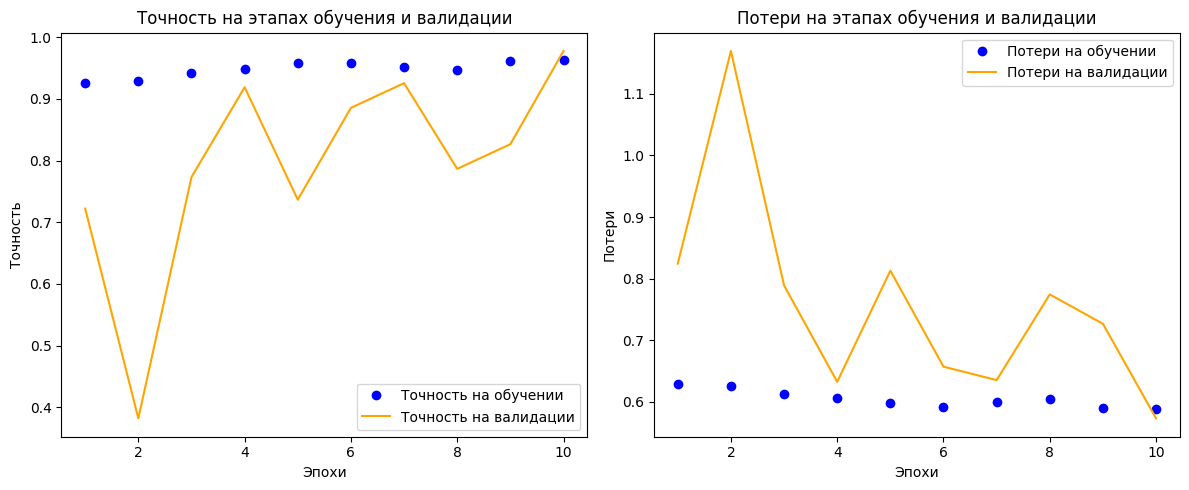 | 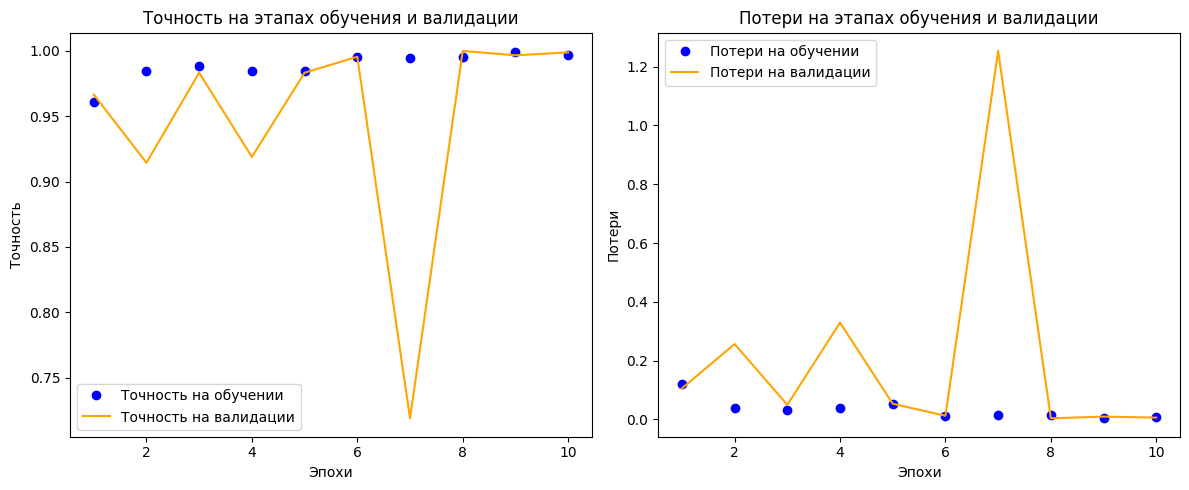 | 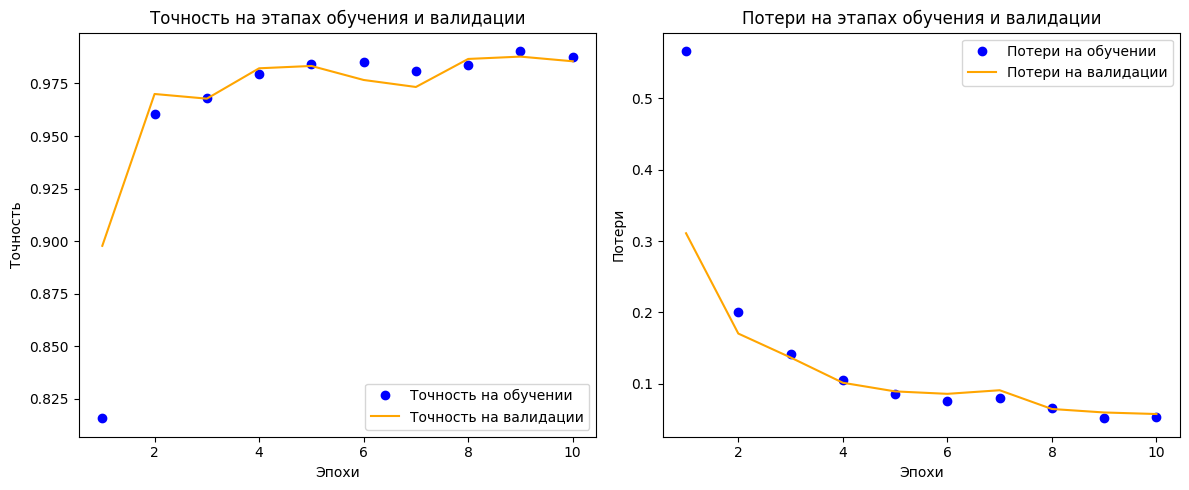 |
| About model | Имплементация ResNet-6 | Дообучение предобученной ResNet-18 с изменением последних слоев  | Fine-tuning предобученной ResNet-18 с заморозкой всех слоев, кроме финальногого измененного слоя |

Итоговые выводы:
- Во всех моделях удалось добиться довольно выского сопоставимого качества на обоих выборках
- ResNet-18 "из коробки" справляется ожидаемо лучше, чем имплементированная ResNet-6
- Loss метрика на кастомном ResNet также значительно уступает коробочным решениям
- Fine-tuning модель обучается быстрее, стабильнее и плавнее, не смотря на проишрыш финальной метрики (на ~1 %), который вероятно можно невелировать подбором гиперпараметров и увеличением количества обучаемых эпох